In [18]:
import pandas as pd

In [19]:
train_df = pd.read_csv('//home/amy/work/RIT/TDess/DSCI-601-Amy/Data/DJI_company/all proper/train/AAPL.csv')
test_df = pd.read_csv('/home/amy/work/RIT/TDess/DSCI-601-Amy/Data/DJI_company/all proper/test/AAPL.csv')
validation_df = pd.read_csv('/home/amy/work/RIT/TDess/DSCI-601-Amy/Data/DJI_company/all proper/validation/AAPL.csv')

## ARIMA

In [20]:
train = train_df['RET']
test = test_df['RET']
validation = validation_df['RET']

Validation MSE: 0.0002490296375582259


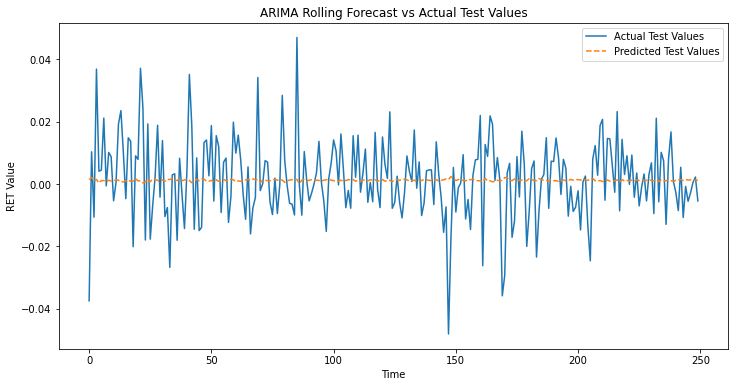

In [34]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# rolling forecast loop 
history = list(train)  
test_predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=(0,0,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    test_predictions.append(yhat)
    obs = test.iloc[t]
    history.append(obs)  # Append actual observation to history

# After the loop, 'model_fit' is the model trained on all of 'train' and 'test'
# forecasting the validation set directly, without further fitting
validation_predictions = model_fit.forecast(steps=len(validation))


validation_mse = mean_squared_error(validation, validation_predictions)
print('Validation MSE:', validation_mse)


test_predictions_df = pd.DataFrame(test_predictions, columns=['Predicted_RET'])
test_predictions_df.to_csv('Predicted_RET_arima_2022_AAPL.csv', index=False)


# Plot predictions against actual values
plt.figure(figsize=(12, 6))
plt.plot(test.values, label='Actual Test Values')
plt.plot(test_predictions_df, label='Predicted Test Values', linestyle='--')
plt.title('ARIMA Rolling Forecast vs Actual Test Values')
plt.xlabel('Time')
plt.ylabel('RET Value')
plt.legend()
plt.show()


## Random Forest

In [22]:
# Feature selection
df_train_X = train_df[['VOL_CHANGE', 'BA_SPREAD', 'ILLIQUIDITY', 'sprtrn', 'TURNOVER']]
df_test_X = test_df[['VOL_CHANGE', 'BA_SPREAD', 'ILLIQUIDITY', 'sprtrn', 'TURNOVER']]
df_val_X = validation_df[['VOL_CHANGE', 'BA_SPREAD', 'ILLIQUIDITY', 'sprtrn', 'TURNOVER']]

# Target Variable selection
df_train_y = train_df[['RET']]
df_test_y = test_df[['RET']]
df_val_y = validation_df[['RET']]

In [23]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Initialize the MinMaxScalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit the scaler to the training data and transform it
normalized_data_trainX = scaler_X.fit_transform(df_train_X)
normalized_data_testX = scaler_X.transform(df_test_X)
normalized_data_valX = scaler_X.transform(df_val_X)

# Assuming you decide to normalize the target variable
normalized_data_trainy = scaler_y.fit_transform(df_train_y)
normalized_data_testy = scaler_y.transform(df_test_y)
normalized_data_valy = scaler_y.transform(df_val_y)

# Convert the normalized data back into DataFrames
normalized_TrainX = pd.DataFrame(normalized_data_trainX, columns=df_train_X.columns)
normalized_TestX = pd.DataFrame(normalized_data_testX, columns=df_test_X.columns)
normalized_ValX = pd.DataFrame(normalized_data_valX, columns=df_val_X.columns)
normalized_Trainy = pd.DataFrame(normalized_data_trainy, columns=df_train_y.columns)
normalized_Testy = pd.DataFrame(normalized_data_testy, columns=df_test_y.columns)
normalized_Valy = pd.DataFrame(normalized_data_valy, columns=df_val_y.columns)

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Set the best parameters found by Bayesian optimization
best_params = {
    'max_depth': 11,
    'max_features': 'log2',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 100
}

# Initialize the RandomForestRegressor with the best parameters
tuned_rf = RandomForestRegressor(**best_params, random_state=42)

# Fit the model using the normalized training data
tuned_rf.fit(normalized_TrainX, np.ravel(normalized_Trainy))

# Make predictions on the normalized validation data
predictions_val_normalized = tuned_rf.predict(normalized_ValX)

# Calculate the MSE on the normalized validation data
mse_validation_normalized = mean_squared_error(normalized_Valy, predictions_val_normalized)
print(f"Normalized Validation MSE: {mse_validation_normalized}")



Normalized Validation MSE: 9.846292247485534e-05


In [25]:
from sklearn.metrics import mean_squared_error

# De-normalize the validation predictions
predictions_val_denormalized = scaler_y.inverse_transform(predictions_val_normalized.reshape(-1, 1))

# De-normalize the actual target values for the validation set
denormalized_Valy = scaler_y.inverse_transform(normalized_Valy)

# Calculate the de-normalized MSE for the validation set
mse_validation_denormalized = mean_squared_error(denormalized_Valy, predictions_val_denormalized)

#print(f"De-normalized Validation MSE: {mse_validation_denormalized}")
number_in_scientific_notation = mse_validation_denormalized
formatted_number = format(number_in_scientific_notation, '.20f')  # 20 decimal places

print(formatted_number)

0.00007130191949100776


In [26]:
# Predictions on the normalized validation data
predictions_val_normalized = tuned_rf.predict(normalized_ValX)

# De-normalize these predictions to get them back on the original scale
predictions_val_denormalized = scaler_y.inverse_transform(predictions_val_normalized.reshape(-1, 1))

# Predictions on the normalized test data
predictions_test_normalized = tuned_rf.predict(normalized_TestX)

# De-normalize these predictions to get them back on the original scale
predictions_test_denormalized = scaler_y.inverse_transform(predictions_test_normalized.reshape(-1, 1))

# Convert the de-normalized predictions into a DataFrame for easier handling
import pandas as pd

df_predictions_test = pd.DataFrame(predictions_test_denormalized, columns=['Predicted_RET_Test'])

# Display the first few rows of the prediction DataFrames

print("\nTest Predictions:")
print(df_predictions_test.head())



Test Predictions:
   Predicted_RET_Test
0           -0.016930
1            0.005348
2           -0.007391
3            0.021469
4            0.002274


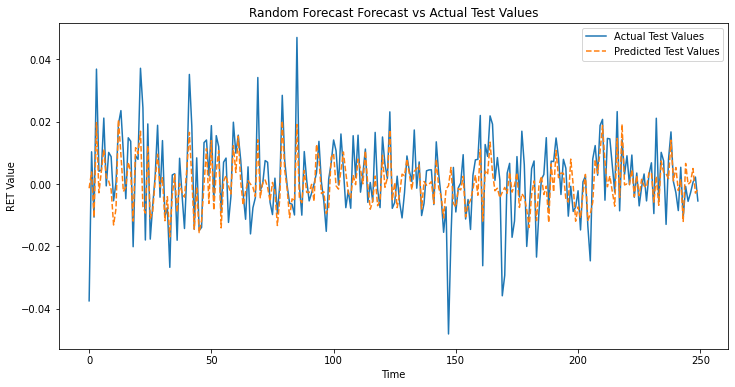

In [33]:
# Plot predictions against actual values
plt.figure(figsize=(12, 6))
plt.plot(df_test_y.values, label='Actual Test Values')
plt.plot(df_predictions_test, label='Predicted Test Values', linestyle='--')
plt.title('Random Forecast Forecast vs Actual Test Values')
plt.xlabel('Time')
plt.ylabel('RET Value')
plt.legend()
plt.show()

In [27]:
# Convert the de-normalized predictions into a DataFrame
df_predictions_test = pd.DataFrame(predictions_test_denormalized, columns=['Predicted_RET_test'])

df_predictions_test.to_csv('predicted_RET_RF_tuned_2022_AAPL.csv', index=False)

In [28]:
from sklearn.metrics import r2_score

# Compute the R² score
r2_validation = r2_score(normalized_Valy, predictions_val_normalized)

print(f"Validation R² score: {r2_validation:.4f}")

Validation R² score: 0.7137


## SVR

In [29]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize the SVR model
svr_model = SVR(kernel='rbf')

# Train the model using the normalized training data
svr_model.fit(normalized_TrainX, np.ravel(normalized_Trainy))  # np.ravel() is used to convert the DataFrame to a 1D array if necessary

# Predict returns on the normalized validation data
predictions_val_normalized = svr_model.predict(normalized_ValX)

# Calculate MSE on the normalized validation data
mse_validation_normalized = mean_squared_error(normalized_Valy, predictions_val_normalized)

print(f"Normalized Validation MSE: {mse_validation_normalized}")


Normalized Validation MSE: 0.00021093566516203256


In [30]:
from sklearn.svm import SVR

# Initialize the SVR model with your chosen kernel and hyperparameters

svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Train the SVR model using the normalized training data
svr_model.fit(normalized_TrainX, np.ravel(normalized_Trainy))


# If needed, you can also make predictions on the normalized test data
predictions_test = svr_model.predict(normalized_TestX)


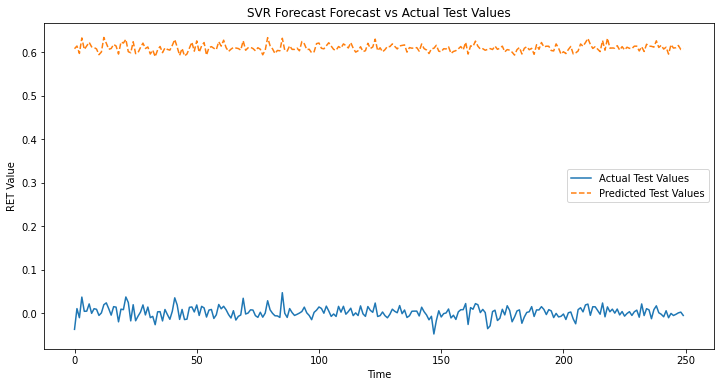

In [35]:
# Plot predictions against actual values
plt.figure(figsize=(12, 6))
plt.plot(df_test_y.values, label='Actual Test Values')
plt.plot(predictions_test, label='Predicted Test Values', linestyle='--')
plt.title('SVR Forecast Forecast vs Actual Test Values')
plt.xlabel('Time')
plt.ylabel('RET Value')
plt.legend()
plt.show()

In [31]:
import pandas as pd

# De-normalize the test predictions
denormalized_predictions_test = scaler_y.inverse_transform(predictions_test.reshape(-1, 1))

# Convert the de-normalized predictions into a DataFrame
df_predictions_test = pd.DataFrame(denormalized_predictions_test, columns=['Predicted_RET'])

# Save the DataFrame to a CSV file
df_predictions_test.to_csv('/home/amy/work/RIT/TDess/DSCI-601-Amy/ProjectCode/Initial Models/predicted_RET_test_svr_2022_AAPL.csv', index=False)


